# Experimento 3 - Órdenes Correlativas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../..")

import pickle
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Use latex
plt.rc("text", usetex=True)

## Generación

Generación de instancias:

In [3]:
from src.generacion import (
    GeneradorInstancias,
    DistribucionIndependiente,
    DistribucionUniforme,
    DistribucionNormal,
)

random.seed(42)

# Generar instancias
N = 1000

generador = GeneradorInstancias(
    cantidad_trabajadores=DistribucionUniforme(5, 10),
    cantidad_ordenes=DistribucionUniforme(5, 20),
    parametros_ordenes=DistribucionIndependiente(
        DistribucionNormal(10000, 2000),
        DistribucionUniforme(3, 10),
    ),
    cantidad_ordenes_correlativas=DistribucionUniforme(2, 10),
)

instancias = [generador.generar_instancia() for _ in range(N)]

with open("datos/instancia.pkl", "wb") as f:
    pickle.dump(instancias, f)

In [4]:
from typing import List
from src.instancia import InstanciaAsignacionCuadrillas


with open("datos/instancia.pkl", "rb") as f:
    instancias: List[InstanciaAsignacionCuadrillas] = pickle.load(f)

## Resolución

In [5]:
from tqdm import tqdm
from src.modelo import ModeloAsignacionCuadrillas
from src.solver import ConfiguracionCPLEX


soluciones = []
for instancia in tqdm(instancias):
    modelo = ModeloAsignacionCuadrillas(instancia)
    solver = modelo.armar_solver(ConfiguracionCPLEX(sin_output=True))

    objetivo, valores = solver.resolver()

    anotada = modelo.anotar_solucion(valores)

    soluciones.append((objetivo, anotada))

with open("datos/solucion.pkl", "wb") as f:
    pickle.dump(soluciones, f)

100%|██████████| 1000/1000 [13:07<00:00,  1.27it/s] 


In [6]:
from typing import List
from src.solucion import SolucionAnotada


with open("datos/solucion.pkl", "rb") as f:
    soluciones: List[SolucionAnotada] = pickle.load(f)

### Distribución de Función Objetivo

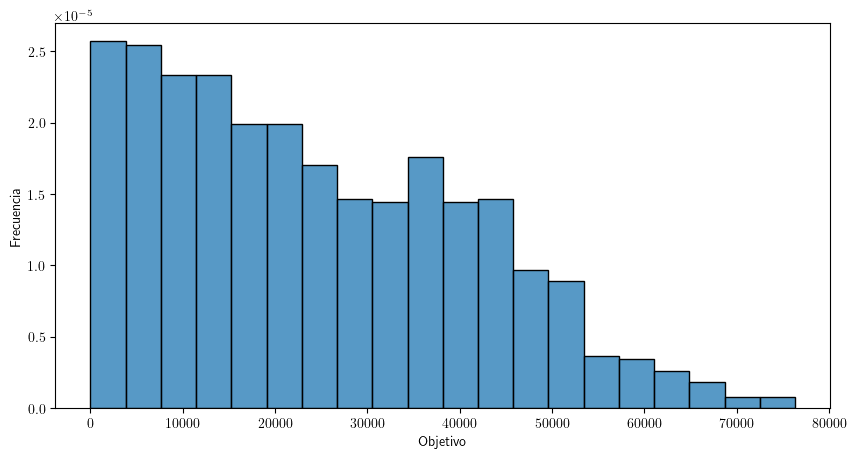

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

optimos = [obj for (obj, _) in soluciones]
sns.histplot(optimos, bins=20, ax=ax, stat="density")

ax.set_xlabel("Objetivo")
ax.set_ylabel("Frecuencia")

# Save
plt.savefig("graficos/distribucion_objetivo.pdf")

plt.show()

In [9]:
pd.Series(optimos).describe()

count     1000.000000
mean     24272.238838
std      16967.447557
min          0.000000
25%      10278.537670
50%      21617.740674
75%      36804.636129
max      76315.554905
dtype: float64

In [15]:
(pd.Series(optimos) <= 1e-8).mean()

np.float64(0.065)

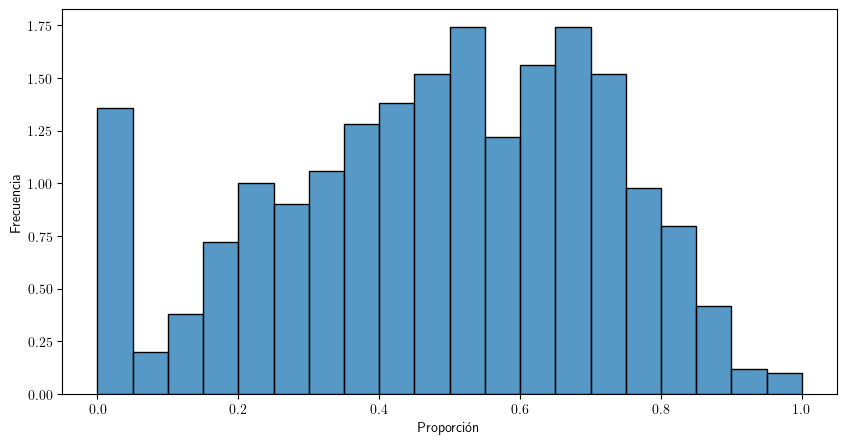

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

proporciones_optimo_ajustado = [
    obj / instancia.beneficio_maximo_pagando_minimo()
    for instancia, (obj, _) in zip(instancias, soluciones)
]

sns.histplot(proporciones_optimo_ajustado, bins=20, ax=ax, stat="density")

ax.set_xlabel("Proporción")
ax.set_ylabel("Frecuencia")

# Save
plt.savefig("graficos/distribucion_proporcion_objetivo_ajustado.pdf")

plt.show()